
# Diffusion Models code starter


## Part 1 — Setup & Baseline

### **Task 1 — MNIST Setup**
**Do:** Load MNIST (use **10,000** train images + full test set). Normalize to **[-1,1]**. Show a small grid of samples.  
**Q:** Why is MNIST good for generative modeling (especially for compex generative models like diffusion models)? What are its modern limitations?


In [9]:
import os, math, time, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', 'data')
os.chdir(GOOGLE_DRIVE_PATH)

Mounted at /content/drive


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True
device

device(type='cuda')

In [31]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

CFG = {
    "batch_size": 128,
    "train_subset": 20000,   # reduce if you need faster iterations
    "timesteps": 1000,
    "lr": 1e-3,
    "epochs": 5,             # 5–10 per assignment
    "save_dir": "./outputs_diffusion_mnist",
    "img_size": 28
}
os.makedirs(CFG["save_dir"], exist_ok=True)

transform = transforms.Compose([
    transforms.ToTensor(),                          # [0,1]
    transforms.Normalize(mean=(0.5,), std=(0.5,))   # -> [-1,1]
])

train_ds_full = datasets.MNIST(root='.', train=True,  transform=transform, download=True)
test_ds       = datasets.MNIST(root='.', train=False, transform=transform, download=True)

idxs = list(range(len(train_ds_full)))
random.shuffle(idxs)
train_subset = Subset(train_ds_full, idxs[:CFG["train_subset"]])

train_loader = DataLoader(train_subset, batch_size=CFG["batch_size"], shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,      batch_size=CFG["batch_size"], shuffle=False, num_workers=2, pin_memory=True)

x0, y0 = next(iter(train_loader))
grid_path = os.path.join(CFG["save_dir"], "mnist_samples.png")
utils.save_image((x0[:16]*0.5+0.5), grid_path, nrow=8)
print(f"[Task 1] Saved sample grid to: {grid_path}")

[Task 1] Saved sample grid to: ./outputs_diffusion_mnist/mnist_samples.png



### **Task 2 — Diffusion Forward Process**
**Do:** Implement the forward (noising) process with a **linear beta** schedule for `T = CFG["timesteps"]`. Visualize frames at `t ∈ {0, T/4, T/2, 3T/4, T}`.  
**Q:** Why add Gaussian noise **gradually** instead of all at once?


In [7]:
# Task 2: Forward (q)
def make_beta_schedule(T, start=1e-4, end=0.02):
    return torch.linspace(start, end, T, device=device)

T = CFG["timesteps"]
betas = make_beta_schedule(T)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1,0), value=1.0)

def q_sample(x0, t, noise=None):
    """
    x0: (B, 1, 28, 28) in [-1, 1]
    t:  (B,) long, 0..T-1
    """
    if noise is None:
        noise = torch.randn_like(x0)
    sqrt_ac = torch.sqrt(alphas_cumprod[t])[:, None, None, None]
    sqrt_om = torch.sqrt(1 - alphas_cumprod[t])[:, None, None, None]
    return sqrt_ac * x0 + sqrt_om * noise

def show_noising_example(batch=None):
    if batch is None:
        batch, _ = next(iter(train_loader))
    x0 = batch.to(device)[:8]
    steps = [0, T//4, T//2, 3*T//4, T-1]
    imgs = []
    for s in steps:
        t = torch.full((x0.size(0),), s, device=device, dtype=torch.long)
        xt = q_sample(x0, t)
        imgs.append(xt.cpu())
    grid = torch.cat(imgs, dim=0)
    path = os.path.join(CFG["save_dir"], "noising_grid.png")
    utils.save_image((grid+1)/2, path, nrow=x0.size(0))
    return path, steps

noising_path, steps_shown = show_noising_example()
print(f"[Task 2] Saved noising grid to: {noising_path} | steps={steps_shown}")

[Task 2] Saved noising grid to: ./outputs_diffusion_mnist/noising_grid.png | steps=[0, 250, 500, 750, 999]



## Part 2 — Train a Lightweight Diffusion Model

### **Task 3 — Small Denoising Network**
**Do:** Implement a small **UNet-like** denoiser (≤ ~2M params) with **timestep embeddings**. Train for ~**2–5 epochs** and print loss.  
**Q:** Why do we use **timestep embeddings**?


[Task 3] TinyUNet params: 0.173M
Epoch 1/5 | loss=0.4091 | time=6.8s
Epoch 2/5 | loss=0.1343 | time=5.0s
Epoch 3/5 | loss=0.0986 | time=7.7s
Epoch 4/5 | loss=0.0836 | time=5.8s
Epoch 5/5 | loss=0.0736 | time=5.4s


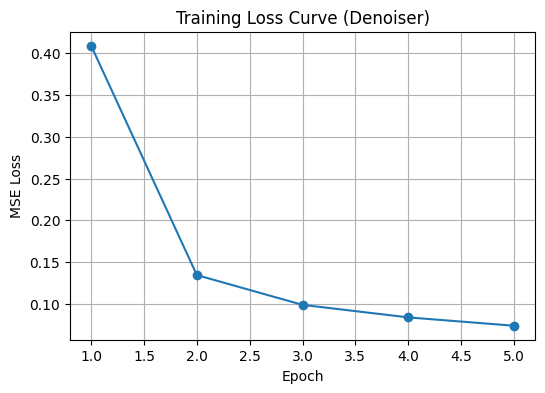

In [10]:
# Task 3: Denoiser (Tiny UNet-like)
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        half = self.dim // 2
        freqs = torch.exp(-math.log(10000) * torch.arange(0, half, device=t.device) / max(half,1))
        args = t[:, None].float() * freqs[None]
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)

        if emb.shape[1] < self.dim:
            emb = F.pad(emb, (0, self.dim - emb.shape[1]))
        return emb

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.time_mlp = nn.Sequential(nn.SiLU(), nn.Linear(time_dim, out_ch))
        self.gn1 = nn.GroupNorm(1, out_ch)
        self.gn2 = nn.GroupNorm(1, out_ch)
    def forward(self, x, t_emb):
        h = F.silu(self.gn1(self.conv1(x)))
        t = self.time_mlp(t_emb)[:, :, None, None]
        h = h + t
        h = F.silu(self.gn2(self.conv2(h)))
        return h

class TinyUNet(nn.Module):
    def __init__(self, time_dim=64, base=32):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.SiLU(),
        )
        self.inc   = nn.Conv2d(1, base, 3, padding=1)
        self.down1 = Block(base, base*2, time_dim)
        self.pool  = nn.AvgPool2d(2)
        self.mid   = Block(base*2, base*2, time_dim)
        self.up    = nn.Upsample(scale_factor=2, mode='nearest')
        self.up1   = Block(base*2, base, time_dim)
        self.outc  = nn.Conv2d(base, 1, 1)

    def forward(self, x, t):
        t_emb = self.time_mlp(t)
        x1 = F.silu(self.inc(x))
        x2 = self.pool(self.down1(x1, t_emb))
        x3 = self.mid(x2, t_emb)
        x4 = self.up(x3)
        x5 = self.up1(x4, t_emb)
        out = self.outc(x5)
        return out

model = TinyUNet().to(device)
params = sum(p.numel() for p in model.parameters())
print(f"[Task 3] TinyUNet params: {params/1e6:.3f}M")

optimizer = torch.optim.AdamW(model.parameters(), lr=CFG["lr"])

def p_losses(model, x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    xt = q_sample(x0, t, noise)
    pred_noise = model(xt, t)
    return F.mse_loss(pred_noise, noise)

def train_denoiser(model, epochs=CFG["epochs"]):
    model.train()
    history = []
    for ep in range(1, epochs+1):
        t0 = time.time()
        losses = []
        for x, _ in train_loader:
            x = x.to(device)
            t = torch.randint(0, T, (x.size(0),), device=device).long()
            loss = p_losses(model, x, t)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        mean_loss = np.mean(losses)
        history.append(mean_loss)
        print(f"Epoch {ep}/{epochs} | loss={mean_loss:.4f} | time={time.time()-t0:.1f}s")
    return model, history

@torch.no_grad()
def show_denoising_example(model, batch=None, steps=None, fname="denoiser_recon_grid.png"):
    model.eval()
    if batch is None:
        batch, _ = next(iter(train_loader))
    x0 = batch.to(device)[:8]  # ground-truth
    if steps is None:
        steps = [0, T//4, T//2, 3*T//4, T-1]

    rows = [x0.cpu()]
    for s in steps:
        t = torch.full((x0.size(0),), s, device=device, dtype=torch.long)
        noise = torch.randn_like(x0)
        xt = q_sample(x0, t, noise=noise)

        pred_noise = model(xt, t)

        ac = alphas_cumprod[s]
        x0_hat = (xt - torch.sqrt(1 - ac) * pred_noise) / torch.sqrt(ac)
        rows.append(x0_hat.clamp(-1, 1).cpu())

    grid = torch.cat(rows, dim=0)
    path = os.path.join(CFG["save_dir"], fname)
    utils.save_image((grid+1)/2, path, nrow=x0.size(0))
    return path

model, loss_history = train_denoiser(model, epochs=CFG["epochs"])

plt.figure(figsize=(6,4))
plt.plot(range(1, len(loss_history)+1), loss_history, marker='o')
plt.title("Training Loss Curve (Denoiser)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.savefig(os.path.join(CFG["save_dir"], "loss_curve.png"))
plt.show()

In [11]:
from PIL import Image

[Task 3] Saved denoiser reconstruction grid to: ./outputs_diffusion_mnist/denoiser_recon_grid.png


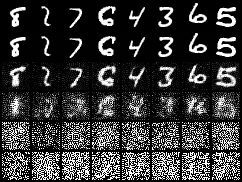

In [12]:
recon_path = show_denoising_example(model, fname="denoiser_recon_grid.png")
print(f"[Task 3] Saved denoiser reconstruction grid to: {recon_path}")

display(Image.open(recon_path))


### **Task 4 — Generate Samples**
**Do:** Implement the reverse process (DDPM sampling). Generate **10** samples and save a grid.  
**Q:** Are samples **diverse** and **recognizable**?


In [13]:
# Task 4: Sampling (p)
@torch.no_grad()
def p_sample(model, xt, t):
    """One reverse diffusion step."""
    beta_t = betas[t][:, None, None, None]
    sqrt_one_minus_ac = torch.sqrt(1 - alphas_cumprod[t])[:, None, None, None]

    pred_noise = model(xt, t)

    x0_hat = (xt - sqrt_one_minus_ac * pred_noise) / torch.sqrt(alphas_cumprod[t])[:, None, None, None]

    coef1 = torch.sqrt(alphas_cumprod_prev[t])[:, None, None, None] * beta_t / (1 - alphas_cumprod[t])[:, None, None, None]
    coef2 = torch.sqrt(alphas[t])[:, None, None, None] * (1 - alphas_cumprod_prev[t])[:, None, None, None] / (1 - alphas_cumprod[t])[:, None, None, None]
    mean = coef1 * x0_hat + coef2 * xt

    if (t == 0).all():
        return mean
    noise = torch.randn_like(xt)
    var = beta_t
    return mean + torch.sqrt(var) * noise


[Task 4] Saved generated samples to: ./outputs_diffusion_mnist/samples_ddpm.png


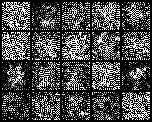

In [14]:
@torch.no_grad()
def p_sample_loop(model, n=10):
    """Run the reverse process to generate n MNIST samples."""
    model.eval()
    xt = torch.randn(n, 1, 28, 28, device=device)  # MNIST size = 28x28
    for s in reversed(range(T)):
        t = torch.full((n,), s, device=device, dtype=torch.long)
        xt = p_sample(model, xt, t)
    x_gen = xt.clamp(-1, 1)
    path = os.path.join(CFG["save_dir"], "samples_ddpm.png")
    utils.save_image((x_gen+1)/2, path, nrow=5)
    return x_gen, path

samples, gen_path = p_sample_loop(model, n=20)
print(f"[Task 4] Saved generated samples to: {gen_path}")

display(Image.open(gen_path))


## Part 3 — Evaluation

### **Task 5 — Lightweight Quantitative Evaluation**
1) Generate 1000 Samples

2) Train a tiny MNIST classifier (2–3 conv layers, 1–2 epochs). Report **accuracy on generated samples**.  

3) Compute the same **sample quality metrics** used to evaluate generated samples as in Assingments 3 & 4 (Hwk 4: Task 7) for the genrated smaple of your trained diffusion model here, complete your table from Assignment 4 with them, and comment on the results.


In [17]:
### Task 5: Tiny Classifier for Evaluation
class TinyCNN(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*14*14, 128)
        self.fc2 = nn.Linear(128, n_classes)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

def train_tiny_classifier(epochs=2):
    clf = TinyCNN().to(device)
    opt = torch.optim.Adam(clf.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    clf.train()
    for ep in range(1, epochs+1):
        losses, correct, total = [], 0, 0
        for x,y in train_loader:
            x,y = x.to(device), y.to(device)
            logits = clf(x)
            loss = criterion(logits, y)
            opt.zero_grad(); loss.backward(); opt.step()
            losses.append(loss.item())
            pred = logits.argmax(dim=1)
            correct += (pred==y).sum().item()
            total += y.size(0)
        print(f"[Classifier] Epoch {ep}/{epochs} | loss={np.mean(losses):.4f} | acc={100*correct/total:.2f}%")
    return clf


In [18]:
@torch.no_grad()
def evaluate_generated_with_classifier(clf, imgs):
    clf.eval()
    logits = clf(imgs)
    preds = logits.argmax(dim=1)
    # classification diversity (entropy of predicted labels)
    hist = torch.bincount(preds, minlength=10).float()
    probs = hist / hist.sum()
    diversity_entropy = -(probs * probs.clamp(min=1e-8).log()).sum().item()
    return preds, diversity_entropy

clf = train_tiny_classifier(epochs=2)
preds, div_entropy = evaluate_generated_with_classifier(clf, samples)

print(f"[Task 5] Predicted labels for generated samples: {preds.tolist()}")
print(f"[Task 5] Diversity entropy of generated samples: {div_entropy:.4f}")

[Classifier] Epoch 1/2 | loss=0.3817 | acc=88.80%
[Classifier] Epoch 2/2 | loss=0.0864 | acc=97.42%
[Task 5] Predicted labels for generated samples: [2, 2, 5, 5, 8, 5, 8, 5, 6, 5, 8, 8, 3, 5, 8, 2, 5, 2, 7, 5]
[Task 5] Diversity entropy of generated samples: 1.4843


#### Preparations for Scores

In [19]:
from torch.utils.data import TensorDataset
from scipy.linalg import sqrtm
from sklearn.metrics.pairwise import rbf_kernel

In [22]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x, return_features=False):
        """
        Defines the forward pass. Can return final logits or intermediate features.

        Args:
            x (torch.Tensor): The input batch of images.
            return_features (bool): If True, returns features from fc1.
                                    If False, returns final logits from fc2.
        """
        x = torch.relu(torch.max_pool2d(self.conv1(x), 2))
        x = torch.relu(torch.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 320)

        features = torch.relu(self.fc1(x))

        if return_features:
            return features

        output = self.fc2(features)
        return output

In [26]:
weights_path = 'lenet_mnist.pth'
classifier = LeNet().to(device)
classifier.load_state_dict(torch.load(weights_path))
classifier.eval()

LeNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [27]:
@torch.no_grad()
def get_activations(images, classifier, batch_size=64):
    """
    Get feature activations from classifier (fc1 layer of LeNet).
    images: torch.Tensor (N, 1, 28, 28), normalized [-1,1]
    """
    classifier.eval()
    dataset = TensorDataset(images)
    loader = DataLoader(dataset, batch_size=batch_size)
    acts = []
    for (batch,) in loader:
        batch = batch.to(device)
        feat = classifier(batch, return_features=True)
        acts.append(feat.cpu().numpy())
    return np.concatenate(acts, axis=0)

def inception_score(images, classifier, batch_size=32, splits=10):
    classifier.eval()
    images = images.view(-1, 1, 28, 28)
    dataset = TensorDataset(images)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    all_preds = []
    with torch.no_grad():
        for batch in dataloader:
            img_batch = batch[0].to(device)
            preds = F.softmax(classifier(img_batch), dim=1)
            all_preds.append(preds.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)

    scores = []
    n_samples = all_preds.shape[0]
    split_size = n_samples // splits
    for i in range(splits):
        part = all_preds[i*split_size:(i+1)*split_size, :]
        p_yx = part
        p_y = np.mean(part, axis=0)
        kl_divs = p_yx * (np.log(p_yx + 1e-10) - np.log(p_y + 1e-10))
        kl_divs = np.sum(kl_divs, axis=1)
        scores.append(np.exp(np.mean(kl_divs)))

    return np.mean(scores), np.std(scores)

def fid_score(real_samples, gen_samples):
    act_real = get_activations(real_samples, classifier)
    act_gen  = get_activations(gen_samples, classifier)
    mu1, sigma1 = act_real.mean(axis=0), np.cov(act_real, rowvar=False)
    mu2, sigma2 = act_gen.mean(axis=0), np.cov(act_gen, rowvar=False)
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def kid_score(real_samples, gen_samples):
    act_real = get_activations(real_samples, classifier)
    act_gen  = get_activations(gen_samples, classifier)
    mmd = rbf_kernel(act_real, act_real).mean() + \
          rbf_kernel(act_gen, act_gen).mean() - \
          2 * rbf_kernel(act_real, act_gen).mean()
    return mmd

#### Computing Scores

In [28]:
def compute_all_metrics(gen_imgs, real_loader, classifier, n_real=1000):
    """
    gen_imgs: torch.Tensor (N, 1, 28, 28), generated samples
    real_loader: DataLoader of real MNIST data
    classifier: pretrained LeNet
    n_real: number of real samples to compare
    """
    # 1) Inception Score
    IS_mean, IS_std = inception_score(gen_imgs, classifier)

    # 2) Collect real MNIST subset
    real_imgs = []
    for x, _ in real_loader:
        real_imgs.append(x)
        if len(torch.cat(real_imgs)) >= n_real:
            break
    real_imgs = torch.cat(real_imgs)[:n_real].to(device)

    # 3) FID
    fid = fid_score(real_imgs, gen_imgs)

    # 4) KID
    kid = kid_score(real_imgs, gen_imgs)

    return IS_mean, IS_std, fid, kid

gen_imgs = samples.detach().cpu()

IS_mean, IS_std, fid, kid = compute_all_metrics(gen_imgs, test_loader, classifier)

print(f"[Metrics]")
print(f"Inception Score: {IS_mean:.4f} ± {IS_std:.4f}")
print(f"FID Score:       {fid:.4f}")
print(f"KID Score:       {kid:.4f}")

[Metrics]
Inception Score: 1.3088 ± 0.2309
FID Score:       1751.6778
KID Score:       0.0868


/tmp/ipython-input-1199578298.py:51: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean = sqrtm(sigma1.dot(sigma2))



## Part 4 — Acceleration via Distillation

### **Task 7 — Simple Distillation for Faster Sampling**
**Goal:** Train a **student** model to mimic a **teacher** model's multi-step denoising in **fewer steps** (e.g., teacher **K=10** steps vs student **1** step).  
**Evaluate:** Compare **speed** (1-step vs K-step) and **quality** (grids + notes).  
**Q:** What **speed/quality trade-off** did you observe?


In [33]:
### Task 7: Distillation (starter)
class StudentTinyUNet(TinyUNet):
    def __init__(self, time_dim=32, base=16):
        super().__init__(time_dim=time_dim, base=base)

@torch.no_grad()
def teacher_generate_k_steps(model, n=10, K=10):
    """
    Generate n samples by running K evenly-spaced reverse steps of the teacher.
    This returns images in [-1,1].
    """
    model.eval()
    xt = torch.randn(n, 1, CFG["img_size"], CFG["img_size"], device=device)
    step_ids = torch.linspace(T-1, 0, steps=K, device=device).long()
    for s in step_ids:
        t = torch.full((n,), int(s.item()), device=device, dtype=torch.long)
        xt = p_sample(model, xt, t)
    return xt.clamp(-1,1)

def save_student_checkpoint(student, optimizer, epoch, loss_history, path):
    state = {
        "epoch": epoch,
        "model_state": student.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "config": CFG,
        "loss_history": loss_history
    }
    torch.save(state, path)
    print(f"[Student CKPT] saved -> {path}")

def load_student_checkpoint(path, student, optimizer=None):
    state = torch.load(path, map_location=device)
    student.load_state_dict(state["model_state"])
    if optimizer is not None:
        optimizer.load_state_dict(state["optimizer_state"])
    print(f"[Student CKPT] loaded from {path} (epoch {state['epoch']})")
    return state

def distill_student(teacher, steps_K=10, student_epochs=2, n_per_batch=64, save_every_epoch=True):

    student = StudentTinyUNet(time_dim=32, base=16).to(device)
    opt = torch.optim.AdamW(student.parameters(), lr=2e-4, weight_decay=0.0)
    loss_history = []

    save_dir = CFG["save_dir"]
    os.makedirs(save_dir, exist_ok=True)

    iterations_per_epoch = max(1, len(train_loader)//(CFG["batch_size"]//n_per_batch + 1))

    for ep in range(1, student_epochs+1):
        student.train()
        t0 = time.time()
        ep_losses = []

        for it in range(iterations_per_epoch):
            with torch.no_grad():
                x_teacher = teacher_generate_k_steps(teacher, n=n_per_batch, K=steps_K)

                z0 = torch.randn_like(x_teacher)

            t_zero = torch.zeros(z0.size(0), dtype=torch.long, device=device)
            pred = student(z0, t_zero)
            loss = F.mse_loss(pred, x_teacher)

            opt.zero_grad()
            loss.backward()
            opt.step()

            ep_losses.append(loss.item())

        mean_loss = float(np.mean(ep_losses))
        loss_history.append(mean_loss)
        print(f"[Distill] Epoch {ep}/{student_epochs} | loss={mean_loss:.6f} | time={time.time()-t0:.1f}s")

    return student, loss_history

In [34]:
import time

In [35]:
@torch.no_grad()
def student_sample(student, n=10, save_name="samples_student.png"):
    """
    Generate n images from student: one forward pass from z0 -> x.
    """
    student.eval()
    z0 = torch.randn(n, 1, CFG["img_size"], CFG["img_size"], device=device)
    t_zero = torch.zeros(n, dtype=torch.long, device=device)
    x = student(z0, t_zero).clamp(-1,1)
    path = os.path.join(CFG["save_dir"], save_name)
    utils.save_image((x+1)/2, path, nrow=5)
    return x, path

@torch.no_grad()
def time_teacher_sampling(teacher, n=100):
    """Time how long teacher takes to generate n samples using full reverse loop (T steps)."""
    t0 = time.time()

    all_samples = []
    bs = 20
    for i in range(0, n, bs):
        nb = min(bs, n - i)
        x_gen, _ = p_sample_loop(teacher, n=nb)
        all_samples.append(x_gen.cpu())
    total = time.time() - t0
    samples = torch.cat(all_samples, dim=0)
    return samples, total

@torch.no_grad()
def time_student_sampling(student, n=100):
    t0 = time.time()
    all_samples = []
    bs = 100
    for i in range(0, n, bs):
        nb = min(bs, n - i)
        x_student, _ = student_sample(student, n=nb, save_name=f"tmp_student_{i}.png")
        all_samples.append(x_student.cpu())
    total = time.time() - t0
    samples = torch.cat(all_samples, dim=0)
    return samples, total

# run distillation and compare

K_teacher = 10
student_epochs = 3
n_eval = 200

student_ckpt_path = os.path.join(CFG["save_dir"], "student_final.pth")
student, student_loss_hist = distill_student(model, steps_K=K_teacher, student_epochs=student_epochs, n_per_batch=64)

save_student_checkpoint(student, torch.optim.AdamW(student.parameters()), student_epochs, student_loss_hist, student_ckpt_path)


print("[Eval] Generating teacher samples (this may take some time)...")
teacher_samples, teacher_time = time_teacher_sampling(model, n=n_eval)
print(f"[Timing] Teacher full sampling: {n_eval} samples in {teacher_time:.2f}s  -> {teacher_time/n_eval:.4f}s per sample")

print("[Eval] Generating student samples (fast)...")
student_samples, student_time = time_student_sampling(student, n=n_eval)
print(f"[Timing] Student sampling: {n_eval} samples in {student_time:.2f}s -> {student_time/n_eval:.4f}s per sample")

teacher_grid_path = os.path.join(CFG["save_dir"], "samples_teacher_full.png")
utils.save_image((teacher_samples[:100]+1)/2, teacher_grid_path, nrow=10)
student_grid_path = os.path.join(CFG["save_dir"], "samples_student_final.png")
utils.save_image((student_samples[:100]+1)/2, student_grid_path, nrow=10)
print(f"[Saved] Teacher grid: {teacher_grid_path}")
print(f"[Saved] Student grid: {student_grid_path}")


[Distill] Epoch 1/3 | loss=0.517553 | time=3.0s
[Distill] Epoch 2/3 | loss=0.512560 | time=2.9s
[Distill] Epoch 3/3 | loss=0.511918 | time=3.1s
[Student CKPT] saved -> ./outputs_diffusion_mnist/student_final.pth
[Eval] Generating teacher samples (this may take some time)...
[Timing] Teacher full sampling: 200 samples in 32.08s  -> 0.1604s per sample
[Eval] Generating student samples (fast)...
[Timing] Student sampling: 200 samples in 0.34s -> 0.0017s per sample
[Saved] Teacher grid: ./outputs_diffusion_mnist/samples_teacher_full.png
[Saved] Student grid: ./outputs_diffusion_mnist/samples_student_final.png
